In [3]:
# for loading/processing the images  
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [10]:
path = r"E:/ccc_read_calories/images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        flowers.append(file.name)

In [11]:
# view the first 10 flower entries
print(flowers[:10])

['001d4fa5efab5b9b96ec7bb240e3107d.jpg', '001e6c69a632525ee7a9af8272fd13f2.jpg', '00de675ee60673b3d99c84176f13b707.jpg', '00feb45c5b4c887882054ff4ae243ffb.jpg', '014bcaaa6c8311322fc6168ef4a2f3a5.jpg', '015d358a6dc454b80cfb98bb0a21843c.jpg', '028911eac384ff4128ddfe917db25005.png', '030e6128f9742d0c9601dab45089f0fe.jpeg', '0a80637034acfe06978b4844bc645325.jpg', '0aafb12ae51c66f1ec282457f7b2d4b1.jpg']


In [12]:
# load the image as a 224x224 array
img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
(224, 224, 3)

(224, 224, 3)


(224, 224, 3)

In [13]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
(1, 224, 224, 3)

(1, 224, 224, 3)


(1, 224, 224, 3)

In [14]:
x = preprocess_input(reshaped_img)

In [15]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 144s 0us/step


In [17]:
features = model.predict(x)
print(features.shape)

1/1 [==============================] - 0s 62ms/step
(1, 4096)


In [18]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [19]:
data = {}
p = r"E:/ccc_read_calories/image_features.pkl"

# lop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)


1/1 [==============================] - 0s 84ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'image_labels.csv'

In [20]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [61]:
kmeans = KMeans(n_clusters=15, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=15, random_state=22)

In [62]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [24]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 1936 to 30


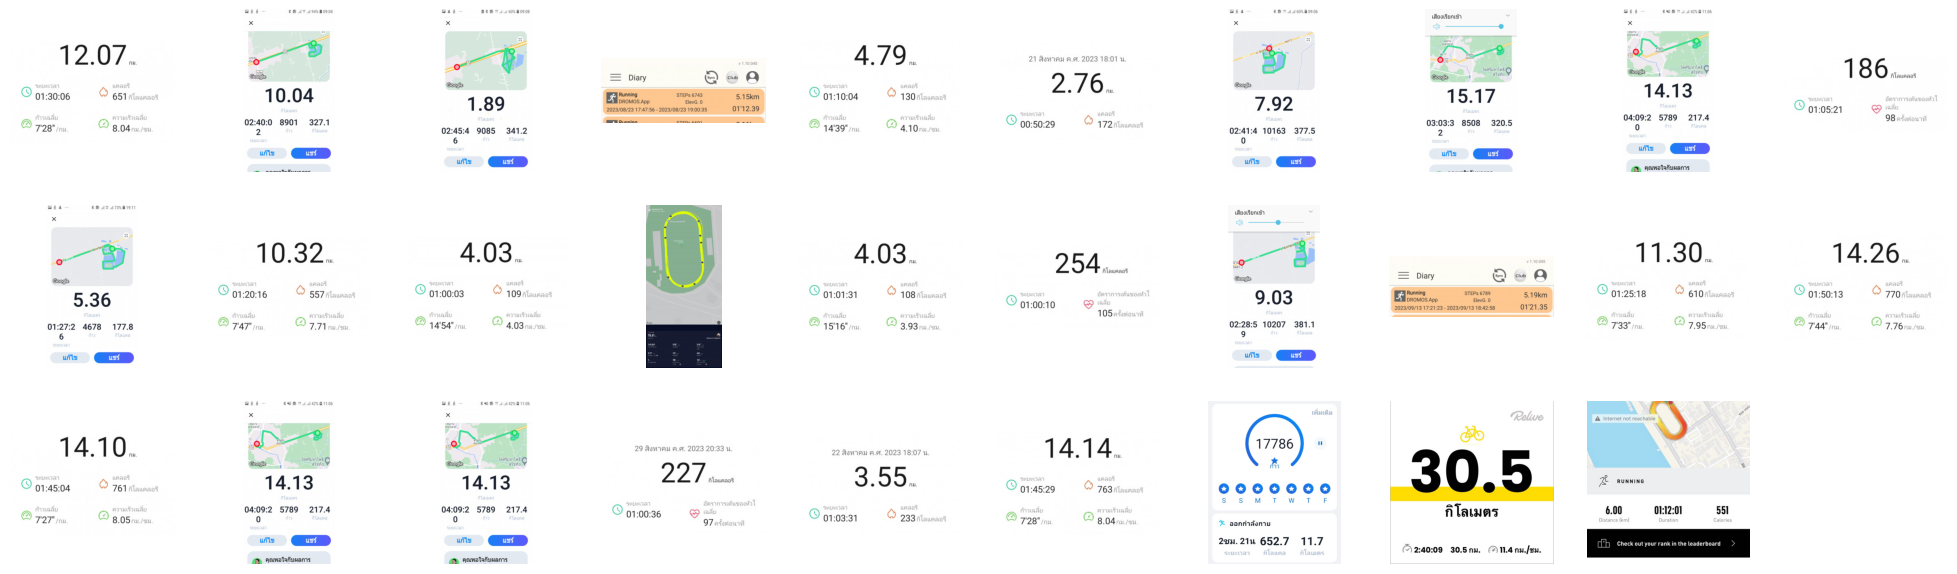

In [65]:
view_cluster(2)

Text(0, 0.5, 'Sum of squared distance')

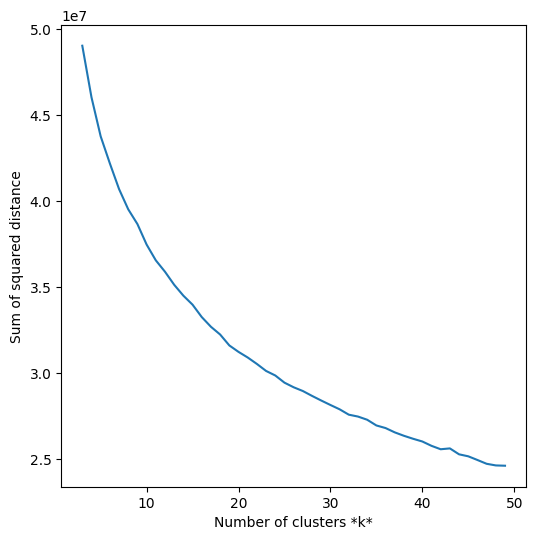

In [26]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')